## Severity: Main Modelling

Note: some will not run because the data are not locally present and they need to be downloaded via datalad. 


In [1]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")
import os
os.chdir(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import bambi as bmb
import arviz as az
import json
import pickle
#import cov_model_management as mm
sys.path.append(os.path.join(root_dir, "covid-fear", "lib")) 
import bammm.bammm as mm
import patsy
from IPython import display

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


$$
\alpha
$$

In [10]:
# data import
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete.csv"))
# hyperparameters
corr_type = "spearman" # used in all analyses

no_covid_factors = 3
if no_covid_factors ==6:
    factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
elif no_covid_factors==3:
    factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic"]
    
print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 3
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF1_CognAnxDepr", "TF2_PhysiolAnx", "TF3_NegativeAffect"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 


State seveirty NaNs: 198 out of entries: 5825


### How traits predict correlation of covid-state-measure and objective severity 

In [3]:
data = df.groupby(by="PROLIFICID")[["PROLIFICID", 'state_severity']+trait_factor_names].mean()

for f in factors:
    data["r_"+f] = np.nan
    for s in df["PROLIFICID"].unique():
        data["r_"+f][s] = df.loc[df["PROLIFICID"].isin([s])][["state_severity", f]].corr(corr_type).loc["state_severity"][f]
data

state_severity  TF3_NegativeAffect  TF2_PhysiolAnx  \
PROLIFICID                                                             
01S0stEpc3rU6YxK        1.154912           -0.270737       -0.592381   
05c9AaLx1V20UAcO        0.976200           -1.495914        1.133909   
07GDvN1Nh0oHcEBM        0.833057           -0.437732       -0.394696   
0OjnLzK5ABd2wO54        0.135050           -0.298534        0.597397   
0Pe1blVigsBRLvBj        1.316176           -0.374222       -0.062450   
...                          ...                 ...             ...   
zNbLeZqHa6wNHRLR        0.820558           -1.342296       -0.386679   
zYWr4nlB9BwdVWFB        1.928073            0.105969        0.222751   
zZGJnUM65XIz0F0X        0.183911           -0.652928       -0.210182   
zlOEoLWEAwlLTGbE        0.354648            0.664146        0.676987   
ztPVSoIVH3QKpGeQ        0.307537           -1.453888        0.372510   

                  TF1_CognAnxDepr  r_F1_CovidAnxietyWorry  \
PROLIFICID                                                  
01S0stEpc3rU6YxK        -0.262363                0.027431   
05c9AaLx1V20UAcO         0.282148               -0.118797   
07GDvN1Nh0oHcEBM        -0.119848               -0.522059   
0OjnLzK5ABd2wO54        -1.489741                0.484393   
0Pe1blVigsBRLvBj         0.093516                0.114035   
...                           ...                     ...   
zNbLeZqHa6wNHRLR        -0.850063               -0.427119   
zYWr4nlB9BwdVWFB        -0.049860               -0.248120   
zZGJnUM65XIz0F0X        -0.444112                0.164972   
zlOEoLWEAwlLTGbE         0.229133                0.302256   
ztPVSoIVH3QKpGeQ        -0.411546                0.234940   

                  r_F2_CovidProbabilityEsts  r_F3_Economic  
PROLIFICID                                                  
01S0stEpc3rU6YxK                  -0.086103      -0.125725  
05c9AaLx1V20UAcO                   0.150376       0.724812  
07GDvN1Nh0oHcEBM                   0.068627       0.151961  
0OjnLzK5ABd2wO54                  -0.117337       0.428733  
0Pe1blVigsBRLvBj                  -0.087719      -0.126316  
...                                     ...            ...  
zNbLeZqHa6wNHRLR                  -0.279473      -0.152166  
zYWr4nlB9BwdVWFB                  -0.139850       0.311278  
zZGJnUM65XIz0F0X                  -0.548400      -0.415067  
zlOEoLWEAwlLTGbE                   0.369925       0.374436  
ztPVSoIVH3QKpGeQ                   0.242470      -0.179217  

[300 rows x 7 columns]

#### look at correlations

<AxesSubplot:>

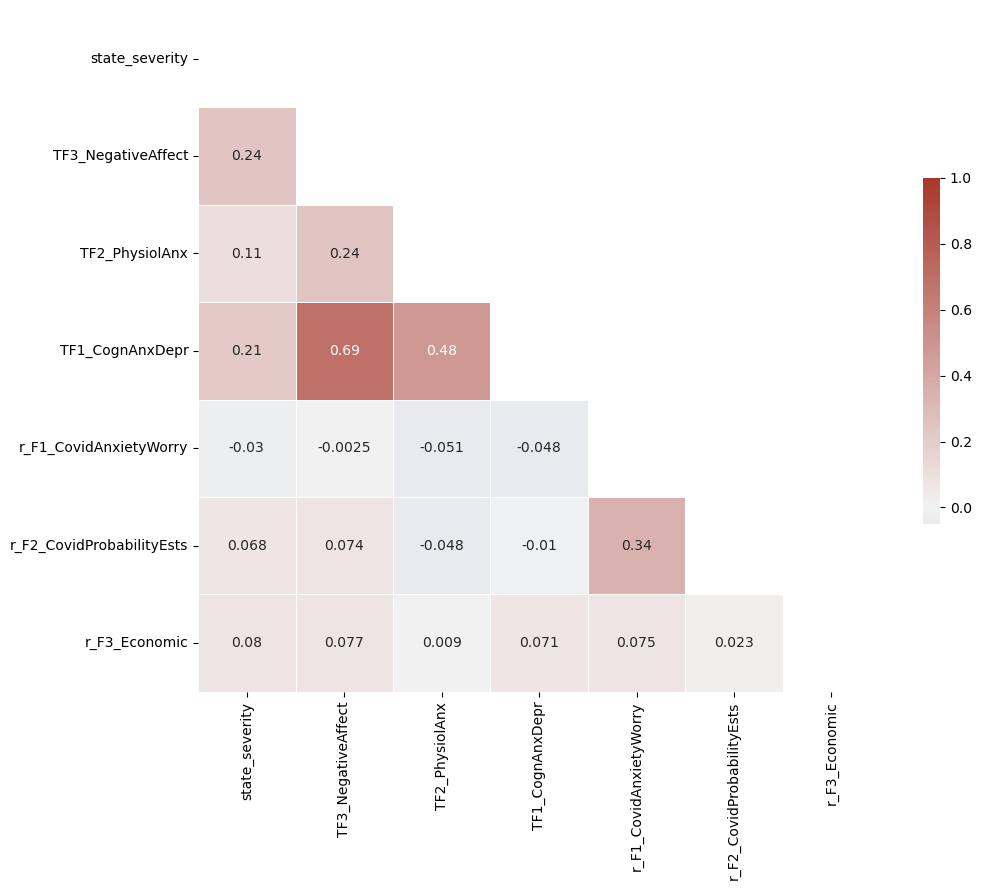

In [4]:

dfl = data.dropna()
# calculate correlation matrix
corr = dfl.corr(corr_type)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", 
                             as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})


### Model with correlation as DV

$r_{state, severity}$ ... correlation of state severity and covid-related state measure (e.g. covid worry) within participant across time

$$
r_{state, severity} = \beta_0 + \beta_1TF1  + \beta_2TF2 + \beta_3TF3 + \beta_4TF4 + \beta_5TF5 + \beta_6TF6 
$$

**Downside** 
- doesn't distinguish between trait effect and trait\*severity interaction

Model F1_alltraits_tf_n3_2_3000 already exist, loading it.
Model F2_alltraits_tf_n3_2_3000 already exist, loading it.
Model F3_alltraits_tf_n3_2_3000 already exist, loading it.


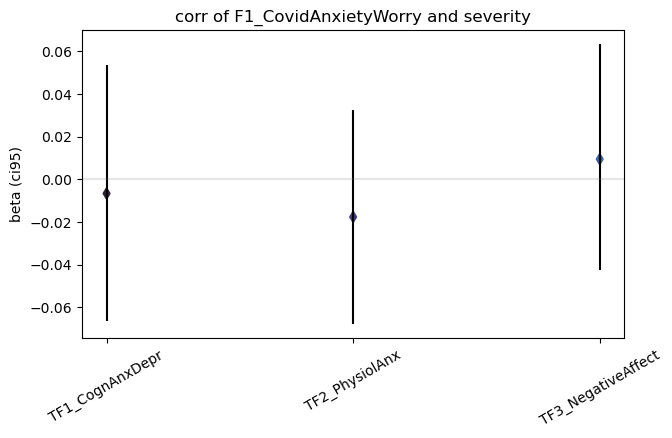

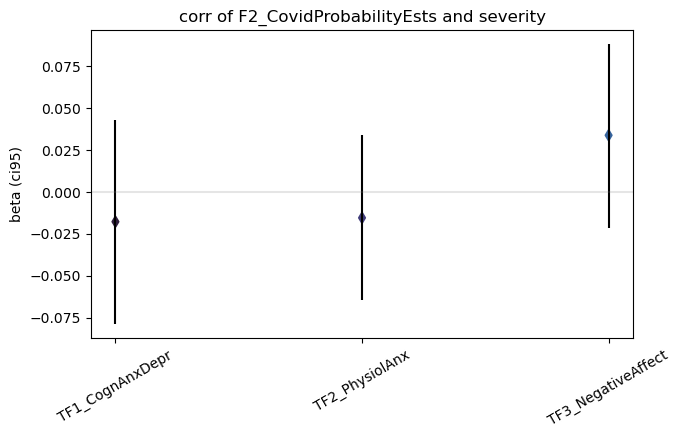

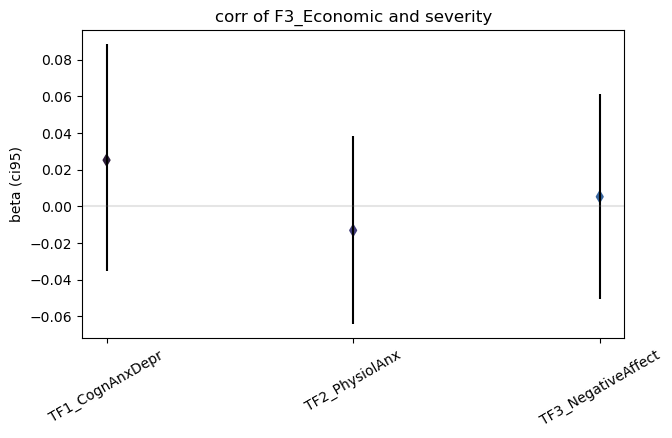

In [11]:
model_constant = "alltraits_tf_n3"
for f_idx, f in enumerate(factors): 
    dfl = data.loc[:,["r_"+f]+trait_factor_names].dropna()
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    if "F"+str(f_idx+1)+"_"+model_constant+"_2_3000" in models.keys():
        mod = models["F"+str(f_idx+1)+"_"+model_constant+"_2_3000"]
    else:
        mod = mm.get_template()
    mod["type"] = "lmm"
    mod["lmm"]["dep_var"] = "r_"+f
    mod["lmm"]["fxeff"] = trait_factor_names 
    mod["lmm"]["rneff"] = []
    mod["est"]["nchains"] = 2
    mod["est"]["nsamples"] = 3000
    mod["name"] = "F"+str(f_idx+1)+"_"+model_constant+"_"+str(mod["est"]["nchains"])+"_"+str(mod["est"]["nsamples"])
    mod["lmm"]["eq"] = mm.generate_equation(mod["lmm"]["dep_var"], mod["lmm"]["fxeff"], mod["lmm"]["rneff"]) 
    mod["location"] = os.path.join("output", "models", "model_data", "traits_predicting_severity_correlations", mod["name"]+".dic" )
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod=mod, data=dfl, override=0)
    models[mod["name"]] = mod
    mm.save_model_info(models, os.path.join(root_dir, "output", "models", "model_database.json"))
    
    
    # PLOT
    tdf = pd.DataFrame()
    for tf in trait_factor_names:
        d = res.posterior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
    # plot the CI97 posterior for the interaction with anxiety
    axs = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs.vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs.axhline(0, alpha=0.2, color='gray')
    axs.set_title("corr of "+f+" and severity")
    axs.set_ylabel("beta (ci95)")
    axs.set_xlabel("")
    axs.set_xticklabels(trait_factor_names, rotation = 30)

In [6]:
df

PROLIFICID GROUP  session  index      PROLIFICID.1  submitdate  \
0     01S0stEpc3rU6YxK    UK        0    217  01S0stEpc3rU6YxK  2020-04-18   
1     01S0stEpc3rU6YxK    UK        1    603  01S0stEpc3rU6YxK  2020-05-04   
2     01S0stEpc3rU6YxK    UK        2    690  01S0stEpc3rU6YxK  2020-05-18   
3     01S0stEpc3rU6YxK    UK        3    980  01S0stEpc3rU6YxK  2020-06-01   
4     01S0stEpc3rU6YxK    UK        4   1456  01S0stEpc3rU6YxK  2020-06-15   
...                ...   ...      ...    ...               ...         ...   
5820  ztPVSoIVH3QKpGeQ    UK       15   4071  ztPVSoIVH3QKpGeQ  2020-10-19   
5821  ztPVSoIVH3QKpGeQ    UK       16   4335  ztPVSoIVH3QKpGeQ  2020-11-02   
5822  ztPVSoIVH3QKpGeQ    UK       17   4531  ztPVSoIVH3QKpGeQ  2020-11-16   
5823  ztPVSoIVH3QKpGeQ    UK       18   4840  ztPVSoIVH3QKpGeQ  2020-12-01   
5824  ztPVSoIVH3QKpGeQ    UK       19   4968  ztPVSoIVH3QKpGeQ  2020-12-14   

      lastpage  sr_age sr_gender sr_postcode  ...  cat_ms  cat_ts  stai_ta_ms  \
0         12.0    32.0         F      DY98SN  ...    high    high        high   
1          8.0    32.0         F      DY98SN  ...    high    high        high   
2          8.0    32.0         F      DY98SN  ...    high    high        high   
3          8.0    32.0         F         DY9  ...    high    high        high   
4          8.0    32.0         F         DY9  ...    high    high        high   
...        ...     ...       ...         ...  ...     ...     ...         ...   
5820       8.0    37.0         M      CW55UG  ...     low     mid         low   
5821       7.0    37.0         M      CW55UG  ...     low     mid         low   
5822       8.0    37.0         M      CW55UG  ...     low     mid         low   
5823       7.0    37.0         M      CW55UG  ...     low     mid         low   
5824      12.0    37.0         M      CW55UG  ...     low     mid         low   

      stai_ta_ts  TF3_NegativeAffect_ms  TF3_NegativeAffect_ts  \
0            mid                    low                    mid   
1            mid                    low                    mid   
2            mid                    low                    mid   
3            mid                    low                    mid   
4            mid                    low                    mid   
...          ...                    ...                    ...   
5820         low                    low                    low   
5821         low                    low                    low   
5822         low                    low                    low   
5823         low                    low                    low   
5824         low                    low                    low   

      TF2_PhysiolAnx_ms  TF2_PhysiolAnx_ts  TF1_CognAnxDepr_ms  \
0                   low                low                 low   
1                   low                low                 low   
2                   low                low                 low   
3                   low                low                 low   
4                   low                low                 low   
...                 ...                ...                 ...   
5820               high               high                 low   
5821               high               high                 low   
5822               high               high                 low   
5823               high               high                 low   
5824               high               high                 low   

      TF1_CognAnxDepr_ts  
0                    mid  
1                    mid  
2                    mid  
3                    mid  
4                    mid  
...                  ...  
5820                 mid  
5821                 mid  
5822                 mid  
5823                 mid  
5824                 mid  

[5825 rows x 286 columns]

### Model 0: traits + severity + traits * severity + session + (session|ID)
e.g.
$$
Worry \sim  Severity + TF_1 + TF_1*Severity  + TF_2 + TF_2*Severity + session + (session|subject) 
$$

In [7]:
from IPython import display
#factors_temp = ["F1_Close_Person_Worry"]
model_constant = "severity_onlysession_slope_tf_f3"
folder = "traits_predicting_severity_correlations"

estimate1 = 1
if estimate1:
    for f_idx, f in enumerate(factors): 
        dfl = df.loc[:,[f, "state_severity", "PROLIFICID", "session"]+trait_factor_names].dropna()
        models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
        if "F"+str(f_idx+1)+"_"+model_constant+"_2_3000" in models.keys():
            mod = models["F"+str(f_idx+1)+"_"+model_constant+"_2_3000"]
        else:
            mod = mm.get_template()
        mod["type"] = "lmm"
        mod["lmm"]["dep_var"] = f
        mod["lmm"]["fxeff"] = ["state_severity"]+trait_factor_names+['state_severity*'+i for i in trait_factor_names]+["session"]
        mod["lmm"]["rneff"] = ["session|PROLIFICID"]
        mod["est"]["nchains"] = 2
        mod["est"]["nsamples"] = 3000
        mod["est"]["ncores"] = 2
        mod["name"] = "F"+str(f_idx+1)+"_"+model_constant+"_"+str(mod["est"]["nchains"])+"_"+str(mod["est"]["nsamples"])
        mod["lmm"]["eq"] = mm.generate_equation(mod["lmm"]["dep_var"], mod["lmm"]["fxeff"], mod["lmm"]["rneff"]) 
        mod["location"] = os.path.join("output", "models", "model_data", folder, mod["name"]+".dic" )
        mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
        mod, res, m = mm.estimate_lmm(mod=mod, data=dfl, override=1)
        models[mod["name"]] = mod
        print(mod["lmm"]["eq"])
        mm.save_model_info(models, os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"))
    



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [F1_CovidAnxietyWorry_sigma, session|PROLIFICID_offset, session|PROLIFICID_sigma, 1|PROLIFICID_offset, 1|PROLIFICID_sigma, session, state_severity:TF1_CognAnxDepr, state_severity:TF2_PhysiolAnx, state_severity:TF3_NegativeAffect, TF1_CognAnxDepr, TF2_PhysiolAnx, TF3_NegativeAffect, state_severity]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 584 seconds.
The number of effective samples is smaller than 25% for some parameters.


F1_CovidAnxietyWorry ~ 0 + state_severity + TF3_NegativeAffect + TF2_PhysiolAnx + TF1_CognAnxDepr + state_severity*TF3_NegativeAffect + state_severity*TF2_PhysiolAnx + state_severity*TF1_CognAnxDepr + session + (session|PROLIFICID)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [F2_CovidProbabilityEsts_sigma, session|PROLIFICID_offset, session|PROLIFICID_sigma, 1|PROLIFICID_offset, 1|PROLIFICID_sigma, session, state_severity:TF1_CognAnxDepr, state_severity:TF2_PhysiolAnx, state_severity:TF3_NegativeAffect, TF1_CognAnxDepr, TF2_PhysiolAnx, TF3_NegativeAffect, state_severity]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 727 seconds.
The number of effective samples is smaller than 25% for some parameters.


F2_CovidProbabilityEsts ~ 0 + state_severity + TF3_NegativeAffect + TF2_PhysiolAnx + TF1_CognAnxDepr + state_severity*TF3_NegativeAffect + state_severity*TF2_PhysiolAnx + state_severity*TF1_CognAnxDepr + session + (session|PROLIFICID)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [F3_Economic_sigma, session|PROLIFICID_offset, session|PROLIFICID_sigma, 1|PROLIFICID_offset, 1|PROLIFICID_sigma, session, state_severity:TF1_CognAnxDepr, state_severity:TF2_PhysiolAnx, state_severity:TF3_NegativeAffect, TF1_CognAnxDepr, TF2_PhysiolAnx, TF3_NegativeAffect, state_severity]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 751 seconds.
The number of effective samples is smaller than 25% for some parameters.


F3_Economic ~ 0 + state_severity + TF3_NegativeAffect + TF2_PhysiolAnx + TF1_CognAnxDepr + state_severity*TF3_NegativeAffect + state_severity*TF2_PhysiolAnx + state_severity*TF1_CognAnxDepr + session + (session|PROLIFICID)


/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F1_severity_onlysession_slope_tf_f3_2_3000.dic
Model F1_severity_onlysession_slope_tf_f3_2_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                     0.024  0.015  -0.004    0.051      0.000   
TF3_NegativeAffect                 0.406  0.081   0.254    0.556      0.002   
TF2_PhysiolAnx                     0.215  0.078   0.069    0.361      0.002   
TF1_CognAnxDepr                   -0.095  0.095  -0.272    0.088      0.003   
state_severity:TF3_NegativeAffect -0.029  0.023  -0.074    0.014      0.000   
state_severity:TF2_PhysiolAnx      0.003  0.021  -0.038    0.042      0.000   
state_severity:TF1_CognAnxDepr    -0.005  0.026  -0.053    0.047      0.000   
session                           -0.000  0.002  -0.005    0.005      0.000   
1|PROLIFICID_sigma                 0.851  0.038   0.781    0.923      0.001   
1|PROLIFICID[01S0stEpc3rU6YxK]     0.654  0.190   0.294    1.004      0.002   
1|PROLIFICID[05c9AaLx1V20UAcO]     0.697  0.233   0.262    1.132      0.005   
1|PROLIFICID[07GDvN1Nh0oHcEBM]    -0.115  0.189  -0.440    0.269      0.002   
1|PROLIFICID[0OjnLzK5ABd2wO54]     0.197  0.234  -0.265    0.617      0.005   
1|PROLIFICID[0Pe1blVigsBRLvBj]    -0.101  0.187  -0.450    0.251      0.002   
1|PROLIFICID[0pbYRGevs5bfDsqG]    -0.908  0.192  -1.275   -0.555      0.002   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                       0.000    4442.0    4372.0    1.0  
TF3_NegativeAffect                   0.002    1093.0    2022.0    1.0  
TF2_PhysiolAnx                       0.002    1071.0    2066.0    1.0  
TF1_CognAnxDepr                      0.002     983.0    1582.0    1.0  
state_severity:TF3_NegativeAffect    0.000    6744.0    4465.0    1.0  
state_severity:TF2_PhysiolAnx        0.000    8546.0    5314.0    1.0  
state_severity:TF1_CognAnxDepr       0.000    5913.0    4336.0    1.0  
session                              0.000    3279.0    4428.0    1.0  
1|PROLIFICID_sigma                   0.001    1599.0    2587.0    1.0  
1|PROLIFICID[01S0stEpc3rU6YxK]       0.001    8762.0    4478.0    1.0  
1|PROLIFICID[05c9AaLx1V20UAcO]       0.003    2596.0    3581.0    1.0  
1|PROLIFICID[07GDvN1Nh0oHcEBM]       0.002    8205.0    4209.0    1.0  
1|PROLIFICID[0OjnLzK5ABd2wO54]       0.004    2119.0    3019.0    1.0  
1|PROLIFICID[0Pe1blVigsBRLvBj]       0.002    7798.0    4390.0    1.0  
1|PROLIFICID[0pbYRGevs5bfDsqG]       0.002    6703.0    4040.0    1.0

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F2_severity_onlysession_slope_tf_f3_2_3000.dic
Model F2_severity_onlysession_slope_tf_f3_2_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                     0.050  0.015   0.019    0.077      0.000   
TF3_NegativeAffect                 0.001  0.083  -0.150    0.158      0.003   
TF2_PhysiolAnx                     0.208  0.076   0.064    0.348      0.002   
TF1_CognAnxDepr                    0.066  0.091  -0.104    0.235      0.003   
state_severity:TF3_NegativeAffect  0.020  0.025  -0.028    0.064      0.000   
state_severity:TF2_PhysiolAnx     -0.006  0.022  -0.046    0.036      0.000   
state_severity:TF1_CognAnxDepr    -0.024  0.028  -0.075    0.028      0.000   
session                            0.000  0.002  -0.004    0.004      0.000   
1|PROLIFICID_sigma                 0.821  0.037   0.754    0.891      0.001   
1|PROLIFICID[01S0stEpc3rU6YxK]    -0.571  0.196  -0.935   -0.194      0.002   
1|PROLIFICID[05c9AaLx1V20UAcO]    -0.329  0.238  -0.792    0.102      0.005   
1|PROLIFICID[07GDvN1Nh0oHcEBM]     1.555  0.196   1.183    1.911      0.002   
1|PROLIFICID[0OjnLzK5ABd2wO54]     0.629  0.234   0.198    1.071      0.005   
1|PROLIFICID[0Pe1blVigsBRLvBj]    -0.734  0.199  -1.105   -0.371      0.002   
1|PROLIFICID[0pbYRGevs5bfDsqG]    -1.104  0.199  -1.490   -0.736      0.002   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                       0.000    5186.0    4641.0    1.0  
TF3_NegativeAffect                   0.002     920.0    1930.0    1.0  
TF2_PhysiolAnx                       0.001    1341.0    2396.0    1.0  
TF1_CognAnxDepr                      0.002    1053.0    2101.0    1.0  
state_severity:TF3_NegativeAffect    0.000    7419.0    4425.0    1.0  
state_severity:TF2_PhysiolAnx        0.000    8207.0    5276.0    1.0  
state_severity:TF1_CognAnxDepr       0.000    7287.0    4841.0    1.0  
session                              0.000    4365.0    3962.0    1.0  
1|PROLIFICID_sigma                   0.001    1887.0    3264.0    1.0  
1|PROLIFICID[01S0stEpc3rU6YxK]       0.002    8640.0    4427.0    1.0  
1|PROLIFICID[05c9AaLx1V20UAcO]       0.003    2418.0    3718.0    1.0  
1|PROLIFICID[07GDvN1Nh0oHcEBM]       0.002    6934.0    4514.0    1.0  
1|PROLIFICID[0OjnLzK5ABd2wO54]       0.003    2479.0    3361.0    1.0  
1|PROLIFICID[0Pe1blVigsBRLvBj]       0.002    8372.0    4753.0    1.0  
1|PROLIFICID[0pbYRGevs5bfDsqG]       0.002    8095.0    4050.0    1.0

/data/drive/postdoc/Project4_covid/output/models/model_data/traits_predicting_severity_correlations/F3_severity_onlysession_slope_tf_f3_2_3000.dic
Model F3_severity_onlysession_slope_tf_f3_2_3000 already exist, loading it.


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
state_severity                     0.154  0.016   0.124    0.185      0.000   
TF3_NegativeAffect                 0.221  0.079   0.075    0.371      0.002   
TF2_PhysiolAnx                    -0.037  0.075  -0.183    0.099      0.002   
TF1_CognAnxDepr                    0.033  0.088  -0.136    0.196      0.002   
state_severity:TF3_NegativeAffect -0.051  0.025  -0.098   -0.003      0.000   
state_severity:TF2_PhysiolAnx      0.038  0.023  -0.006    0.080      0.000   
state_severity:TF1_CognAnxDepr     0.019  0.029  -0.036    0.073      0.000   
session                           -0.000  0.002  -0.005    0.004      0.000   
1|PROLIFICID_sigma                 0.824  0.037   0.757    0.894      0.001   
1|PROLIFICID[01S0stEpc3rU6YxK]    -0.607  0.202  -0.966   -0.205      0.002   
1|PROLIFICID[05c9AaLx1V20UAcO]    -0.263  0.241  -0.710    0.184      0.004   
1|PROLIFICID[07GDvN1Nh0oHcEBM]    -0.514  0.199  -0.891   -0.156      0.002   
1|PROLIFICID[0OjnLzK5ABd2wO54]    -1.477  0.241  -1.925   -1.033      0.004   
1|PROLIFICID[0Pe1blVigsBRLvBj]     0.575  0.201   0.197    0.946      0.002   
1|PROLIFICID[0pbYRGevs5bfDsqG]    -0.308  0.205  -0.703    0.063      0.002   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
state_severity                       0.000    4675.0    4637.0    1.0  
TF3_NegativeAffect                   0.002    1304.0    2231.0    1.0  
TF2_PhysiolAnx                       0.001    1499.0    2545.0    1.0  
TF1_CognAnxDepr                      0.002    1392.0    2048.0    1.0  
state_severity:TF3_NegativeAffect    0.000    6717.0    5022.0    1.0  
state_severity:TF2_PhysiolAnx        0.000    8379.0    5143.0    1.0  
state_severity:TF1_CognAnxDepr       0.000    6346.0    5070.0    1.0  
session                              0.000    4820.0    4622.0    1.0  
1|PROLIFICID_sigma                   0.001    1795.0    2915.0    1.0  
1|PROLIFICID[01S0stEpc3rU6YxK]       0.002    9263.0    4526.0    1.0  
1|PROLIFICID[05c9AaLx1V20UAcO]       0.003    3060.0    4226.0    1.0  
1|PROLIFICID[07GDvN1Nh0oHcEBM]       0.002    9142.0    4118.0    1.0  
1|PROLIFICID[0OjnLzK5ABd2wO54]       0.003    3317.0    3733.0    1.0  
1|PROLIFICID[0Pe1blVigsBRLvBj]       0.002    6932.0    4542.0    1.0  
1|PROLIFICID[0pbYRGevs5bfDsqG]       0.002   10253.0    4567.0    1.0

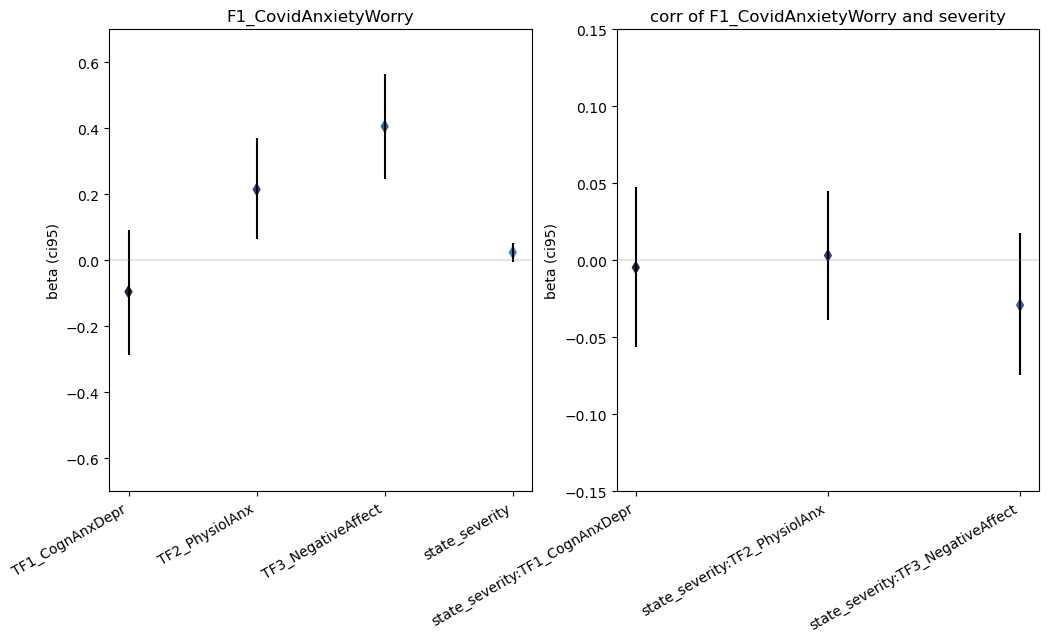

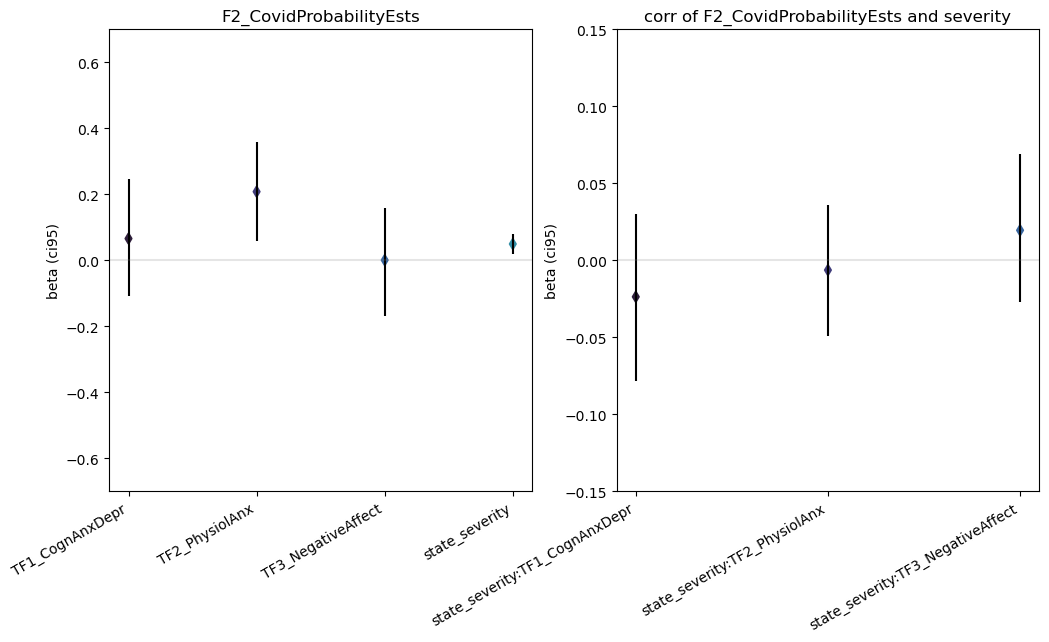

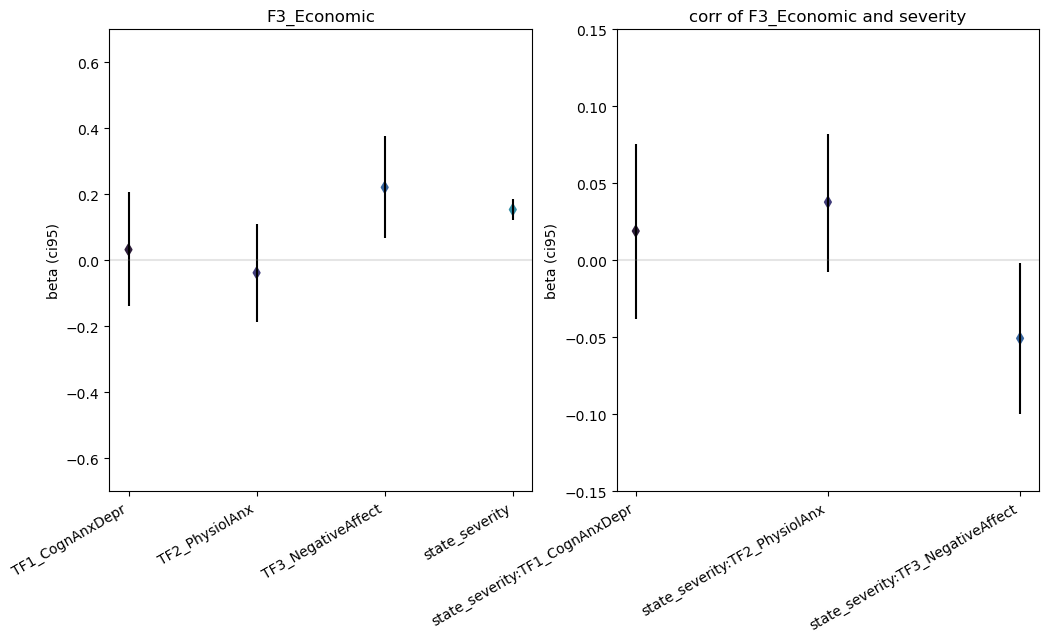

In [12]:
model_constant = "severity_onlysession_slope_tf_f3"
ylims = [[-0.7,0.7], [-0.15, 0.15], [-0.02, 0.02]]
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_2_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    print(mod["current_sys_location"])
    mod, res,m  = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                        ['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
        axs[gr_idx].set_ylim(ylims[gr_idx])

### Model 1: traits + severity + traits * severity + (session|ID)
e.g.
$$
Worry \sim  Severity + TF_1 + TF_1*Severity  + TF_2 + TF_2*Severity + (session|subject) 
$$

I also fitted this in R and the results are nearly identical

In [ ]:
trait_factor_names+['state_severity']
# include state severity in the model !
#["state_severity"]+trait_factor_names+['state_severity*'+i for i in trait_factor_names]
df.loc[:,trait_factor_names+['state_severity']].describe().T


In [ ]:
from IPython import display
#factors_temp = ["F1_Close_Person_Worry"]
model_constant = "severity_noslope_ND"
estimate1 = 0
if estimate1:
    for f_idx, f in enumerate(factors): 
        dfl = df.loc[:,[f, "state_severity", "PROLIFICID", "session"]+trait_factor_names].dropna()
        models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
        if "F"+str(f_idx+1)+"_"+model_constant+"_2_3000" in models.keys():
            mod = models["F"+str(f_idx+1)+"_"+model_constant+"_2_3000"]
        else:
            mod = mm.get_template()
        mod["type"] = "lmm"
        mod["lmm"]["dep_var"] = f
        mod["lmm"]["fxeff"] = ["state_severity"]+trait_factor_names+['state_severity*'+i for i in trait_factor_names]
        mod["lmm"]["rneff"] = ["session|PROLIFICID"]
        mod["est"]["nchains"] = 2
        mod["est"]["nsamples"] = 3000
        mod["est"]["ncores"] = 2
        mod["name"] = "F"+str(f_idx+1)+"_"+model_constant+"_"+str(mod["est"]["nchains"])+"_"+str(mod["est"]["nsamples"])
        mod["lmm"]["eq"] = mm.generate_equation(mod["lmm"]["dep_var"], mod["lmm"]["fxeff"], mod["lmm"]["rneff"]) 
        mod["location"] = os.path.join("output", "models", "model_data", "traits_predicting_severity_correlations", mod["name"]+".dic" )
        mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
        mod, res, m = mm.estimate_lmm(mod=mod, data=dfl, override=0)
        models[mod["name"]] = mod
        print(mod["lmm"]["eq"])
        mm.save_model_info(models, os.path.join(root_dir, "output", "models", "model_database.json"))
    



In [ ]:
model_constant = "severity_noslope_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")

In [ ]:
from IPython import display
pd.set_option('display.max_rows', 500)
results_table = az.summary(res)
results_table.head(20)
# model comparison, nesting might not makes sense, sess only 1 data point
#sess into slpe
m

### With random slopes


#### How to best structure the random effects structure

Simplified example, if we had only two trait factors $TF_1$ and $TF_2$. 
$St$ = state severity

Model 1 (above) ("noslopes")
$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + (sess| id) 
$$



Model 2 - with slopes

$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + (1 + TF_1 + TF_2 + sess | id) 
$$

Model 3 - also with interaction slopes

$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + (1 + TF_1 + St*TF_1 + TF_2 + St*TF_2 + sess | id) 
$$


Model 4  
The random slopes for traits didn't make sense beacuse they are fixed within participant.
What does make sense thought is to model the session as var of interest

$$
Worry \sim St + TF_1 + St*TF_1 + TF_2 + St*TF_2 + TF_1*sess + St*TF_1*sess + TF_2*sess + St*TF_2*sess + (1 + sess | id) 
$$



### Model 2: random slopes  severity + trait + severity\*trait + (1 + trait + session|subject)

In [ ]:
model_constant = "severity_slopes_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.03,0.97)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")

### Model 3: random slopes and interactions  severity + trait + severity\*trait + (1 + trait + session + trait\*severity|subject)

In [ ]:

model_constant = "severity_maxmodel_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],['state_severity:'+i for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")

### Model4: No random slopes (except session) but session as fixed    
### *severity + trait + trait\*sess + (sess|subejct)*


In [ ]:
ylims = [[-1,1], [-0.3, 0.3], [-0.02, 0.02]]
model_constant = "severity_slopes_and_session_ND"
folder = "traits_predicting_severity_correlations"
for f_idx, f in enumerate(factors): 
    models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
    mod = models["F"+str(f_idx+1)+"_"+model_constant+"_4_3000"]
    # assumes that models have been estimated
    mod["current_sys_location"] = os.path.join(root_dir, mod["location"])
    print(mod["current_sys_location"])
    mod, res, m = mm.estimate_lmm(mod, [], override=0)
    # add diagnostics
    #az.plot_trace(res)
    display.display(az.summary(res).head(15))

    # PLOT
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                        ['state_severity:'+i for i in trait_factor_names],
                                        ['state_severity:'+i+":session" for i in trait_factor_names]]):
        tdf = pd.DataFrame()
        for tf in beta_group:
            d = res.posterior[tf].stack(draws=("chain", "draw"))
            dt = pd.DataFrame(d, columns=["sample"])
            dt.loc[:,"trait_factor"] = tf
            tdf = pd.concat([tdf, dt])
        tdf
        axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                      data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                      markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
        bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
        axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
        axs[gr_idx].axhline(0, alpha=0.2, color='gray')
        if gr_idx == 0:
            axs[gr_idx].set_title(f)
        elif gr_idx == 1:
            axs[gr_idx].set_title("corr of "+f+" and severity")
        axs[gr_idx].set_ylabel("beta (ci95)")
        axs[gr_idx].set_xlabel("")
        axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
        axs[gr_idx].set_ylim(ylims[gr_idx])

### Model comparison 

**NOTE (!)** higher WAIC/LOO values are better - see Vehtari et al 2017 or https://arviz-devs.github.io/arviz/api/generated/arviz.compare.html#arviz.compare 


In [ ]:
model_constants = ["severity_noslope",  "severity_maxmodel"]
folder = "traits_predicting_severity_correlations"
models = json.load(open(os.path.join(root_dir, "covid-fear", "model_dbs", "model_database.json"), "r")) 
for f_idx, f in enumerate(factors):    
    mod1 = models["F"+str(f_idx+1)+"_severity_noslope_ND_4_3000"]
    mod1["current_sys_location"] = os.path.join(root_dir, mod1["location"])
    mod1, res_m1, m = mm.estimate_lmm(mod1, [], override=0)
    
    mod2 = models["F"+str(f_idx+1)+"_severity_slopes_ND_4_3000"]
    mod2["current_sys_location"] = os.path.join(root_dir, mod2["location"])
    mod2, res_m2, m = mm.estimate_lmm(mod2, [], override=0)
    
    mod3 = models["F"+str(f_idx+1)+"_severity_maxmodel_ND_4_3000"]
    mod3["current_sys_location"] = os.path.join(root_dir, mod3["location"])
    mod3, res_m3, m = mm.estimate_lmm(mod3, [], override=0)
    
    mod4 = models["F"+str(f_idx+1)+"_severity_slopes_and_session_ND_4_3000"]
    mod4["current_sys_location"] = os.path.join(root_dir, mod4["location"])
    mod4, res_m4, m = mm.estimate_lmm(mod4, [], override=0)
    
    comp = az.compare({"noslopes": res_m1, "slopes": res_m2, "maximal": res_m3, "session_ints": res_m4}, ic="waic",method="pseudo-BMA")
    display.display(comp)
    az.plot_compare(comp, insample_dev=False);

### example of prior distributions

In [ ]:
eq = mod["lmm"]["eq"]
m = bmb.Model(eq, dfl, family="gaussian", link="identity")
m.build()
prior = m.prior_predictive(1000)

In [ ]:
# plot prior
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for gr_idx, beta_group in enumerate([trait_factor_names+['state_severity'],
                                    ['state_severity:'+i for i in trait_factor_names],
                                    ['state_severity:'+i+":session" for i in trait_factor_names]]):
    tdf = pd.DataFrame()
    for tf in beta_group:
        d = prior.prior[tf].stack(draws=("chain", "draw"))
        dt = pd.DataFrame(d, columns=["sample"])
        dt.loc[:,"trait_factor"] = tf
        tdf = pd.concat([tdf, dt])
    tdf
    axs[gr_idx] = sns.pointplot(x="trait_factor", y= "sample",
                  data=tdf, dodge=.532, join=False, palette=sns.color_palette("mako",6),
                  markers="d", scale=.75, ci=None, ax =axs[gr_idx]);
    bounds = tdf.groupby("trait_factor")['sample'].quantile((0.025,0.975)).unstack().reset_index().sort_values(by="trait_factor")
    axs[gr_idx].vlines(bounds.trait_factor, bounds.iloc[:,1], bounds.iloc[:,2], colors='black')
    axs[gr_idx].axhline(0, alpha=0.2, color='gray')
    if gr_idx == 0:
        axs[gr_idx].set_title(f)
    elif gr_idx == 1:
        axs[gr_idx].set_title("corr of "+f+" and severity")
    axs[gr_idx].set_ylabel("beta (ci95)")
    axs[gr_idx].set_xlabel("")
    axs[gr_idx].set_xticklabels(beta_group, rotation = 30, ha="right")
    #axs[gr_idx].set_ylim(ylims[gr_idx])